Discuss: which gear type I chose, how the model accuracy varies across gear types, how I could combine all gear types into one model using interactions.

## __Imports__

In [390]:
#General
from collections import defaultdict
from functools import partial

#Data analysis and file operation imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random

#Unsupervised learning 
import hdbscan

#Geospatial data libraries
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider, WIKIMEDIA
from bokeh.models import ColumnDataSource
from bokeh.palettes import PRGn, RdYlGn
from bokeh.transform import linear_cmap
from pyproj import Transformer

In [451]:
my_path = "/home/jonathan/Documents/Py_Projects/gfw_proj/data"
all_files = ["drifting_longlines.csv", "fixed_gear.csv", "pole_and_line.csv", "purse_seines.csv", "trawlers.csv", "trollers.csv"]
dl = ["drifting_longlines.csv"]
tr = ["trawlers.csv"]
gears = dl + tr

'my_path' is the pathname of the directory holding the original data file.

## __File Manipulation__

Now, we will import a custom library to manipulate files in chunks using pandas. 

In [452]:
import file_manip 

Below we use combine_csv_in_chunks, which combines all csv files in csv_name_list. It requires the csv files to have the same schema. Then, add_index_in_chunks adds an index to the overall file. It takes pathnames of the read and write files, the read and write files names, as well as the chunk size to process the file by. 

In [453]:
aggregated_csv_name="aggregated_file.csv"
file_manip.combine_csv_in_chunks(my_path, my_path, gears, out_csv_name=aggregated_csv_name)

In [455]:
file_manip.add_index_in_chunks(my_path, my_path, aggregated_csv_name)

From now on use the indexed version of the combined data file. Next, the records that have neither is_fishing of 0 nor 1 are removed in chunks.

In [456]:
vals_to_keep = [0, 1]
file_manip.remove_records(my_path, "aggregated_file_indexed.csv", vals_to_keep)

Load the whole dataset from the csv created by the above manipulation functions. The whole dataset (where is_fishing is 0 or 1) is loaded because we will be using cross validation, which implicitly performs the training and testing splits.

In [457]:
original_full = pd.read_csv('/home/jonathan/Documents/Py_Projects/gfw_proj/data/aggregated_file_indexed_filtered.csv')

Make a copy of the full dataset that will be fitted, transformed, and estimated in the pipeline. The original is kept for reference.

In [480]:
cv_full = original_full.copy()

Make a string gear type variable.

In [481]:
cv_full["gear_type_str"] = cv_full["gear_type"].astype(str)

Encode the string gear type.

In [482]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cv_full["gear_type_str"] = le.fit_transform(cv_full["gear_type_str"])

In [483]:
cv_full["gear_type_str"].value_counts()

0    217737
1    174929
Name: gear_type_str, dtype: int64

cv_full and original_full contain the full unchanged dataset except for the removal of all rows with "is_fishing" values that are not either 0 or 1.

## __Visualization__

Now, before we proceed, let's verify that the rows with "is_fishing" that are not 0 or are 1 are sparse. We will load a random sample called "eda_subset_notnull".

In [ ]:
eda_subset_notnull = file_manip.load_data_random_sample(my_path, "aggregated_file_indexed.csv", 0.2)

Text(0, 0.5, 'Count')

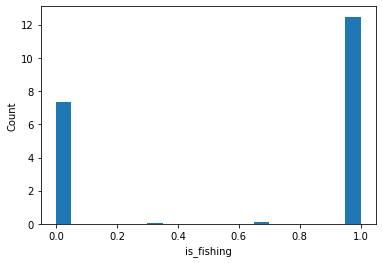

In [38]:
plt.hist(eda_subset_notnull['is_fishing'][eda_subset_notnull['is_fishing']!=-1], density=True, bins=20)
plt.xlabel('is_fishing')
plt.ylabel('Count')

Based on the above plot, it would not make much sense to use a multinomial output as a large majority of AIS broadcasts are voted to be either 0 or 1. The classes would be severely imbalanced if we try to predict classes between 0 and 1 for confidence of is_fishing. Thus, we will stick with a binary response and the filtered dataset (which is called "cv_full").

Because there are multiple time series in the data (one for each boat) and a moving average time series variable will be engineered, let's look at how many observations each vessel has.

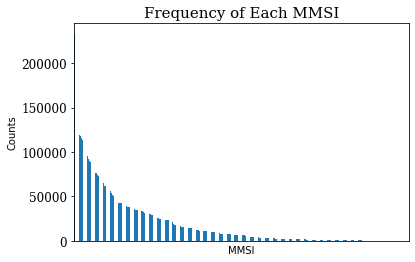

In [11]:
font = {'fontname' : 'serif'}

fig = eda_subset_notnull.mmsi.value_counts().plot(kind='bar')
plt.title("Frequency of Each MMSI", fontsize=15, **font)

plt.xticks([])
plt.yticks(fontsize=12, **font)
plt.ylabel("Counts")
plt.xlabel("MMSI")

plt.show()

Our goal is to split the data into chunks, where each chunk is some number n of values from one MMSI. For each chunk, a time series will be made in the pipeline.

## __Cross Validation Function, Data Splitting, and Preliminary Cleaning__

Cross validation with a single hold out (but possibly more if specified) set will use a custom implementation. Each AIS signal is a time series. These time series will be broken up into contiguous chunks, and the chunks will randomly be assigned to training, test, and validation datasets. In each of the chunks, a times series angular velocity moving average variable will be created, along with the other transformations.

Let's start by completing two data cleaning and preparation tasks:
    
    1) Removing rows with invalid courses (greater than 360 degrees or negative).
    
    2) Converting latitude and longitude to mercator coordiantes.

In [484]:
cv_full = cv_full.loc[(cv_full["course"] <= 360.0) & (cv_full["course"] >= 0.0)]

Now cv_full only consists of rows where the course is between 0.0 and 360.0 inclusive. Next, convert the latitude and longitude spherical coordinates to a set of mercator projection coordinates.

In [485]:
def convert(X, lat_col_name, lon_col_name, crs_from, crs_to):
    #M_x and M_y are the new columns.
    M_x = [] 
    M_y = []
    #Use pyproj Transformer for transformations.
    transformer = Transformer.from_crs(crs_from, crs_to)
    #Iterate through the pandas dataframe. 
    for index, row in X[[lat_col_name, lon_col_name]].iterrows():
        x, y = transformer.transform(row[lat_col_name], row[lon_col_name])
        M_x.append(x); M_y.append(y)
    #Add the new columns to the dataframe.
    X['Mercator_x'] = M_x
    X['Mercator_y'] = M_y

In [486]:
convert(cv_full, 'lat', 'lon', "epsg:4269", "epsg:3847")

The strategy is to make chunks of some size, say 100. If an MMSI has fewer than 100 broadcasts, make it its own smaller chunk. To begin, sort the dataframe by MMSI then by timestamp.

In [487]:
cv_full = cv_full.sort_values(["mmsi", "timestamp"])

In [488]:
cv_full.shape

(392664, 15)

Now that the dataframe is sorted, we can write a function to assign chunks. In TrainValidTest(), the sort parameter is set to false because we have presorted the dataframe within each mmsi. If that were not the case, we could specify sort to True, which will sort the group within each group's iteration. TrainValidTest() is annotated, so following it should be straightforward, but its overall purpose is to create training and test sets, where the training set has a 'fold' attribute, which assigns folds randomly to the chunks.

In [489]:
def TrainValidTest(data, test_proportion=0.2, folds=5, per=100, sort=False, group_by="mmsi", sort_by="timestamp"):
    
    #check if data parameter is a pandas dataframe.
    assert isinstance(data, pd.DataFrame), "data parameter should \
        be a pandas dataframe"
    
    #initialize chunk index. Every 100 rows, this will 
    #be incremented to create the next chunk.
    chunk = 0
    group_chunk_table = defaultdict(list)
    
    #iterate through groups.
    for name, group in data.groupby(group_by):

        #because iterating over groups does not return a view
        #to the rows of the original dataframe 'data', we have 
        #two options: grow a dataframe, which will take up
        #large amounts of space in memory and is notoriously slow,
        #or create a dictionary of the group name as key and the
        #chunk array for the value. The latter is better, so
        #in each group iteration, we will build an array of chunk
        #indices, then make a column in 'data' from the dictionary
        #outside the loop for each group name (mmsi).
        
        if sort:
            #sort the group if sort is True
            group.sort_values([sort_by])
            
        if group.shape[0] < per:
            #if the group size is less than the per parameter,
            #give the group its own chunk index.
            group_chunk_table[name] = (np.ones(group.shape[0])*chunk).astype(int)   
            chunk += 1
            
        else:
            #for every 'per' rows within the group, 
            #give it a chunk index. Then increment
            #the chunk index.
            num_chunks = group.shape[0]//per
            remainder = group.shape[0]%per
            #chunk_array = np.array([])
            for sub_chunk in range(chunk, chunk + num_chunks):
                group_chunk_table[name] = np.concatenate((group_chunk_table[name], 
                                             np.ones(per)*sub_chunk)).astype(int)
            
            if remainder:
                #include the remainders in the final chunk.
                #Thus, the final chunk will be of length
                #per + remainder.
                group_chunk_table[name] = np.concatenate((group_chunk_table[name], 
                                             np.ones(remainder)*chunk+num_chunks)).astype(int)
                
            #increment chunks by the number of chunks 
            #we covered in this group.
            chunk = chunk + num_chunks + 1
    
    #create the chunk column. Use the key in the 'group_chunks_table'
    #to determine where the corresponding list should go.
    data["chunk"] = -1
    for key, arr in group_chunk_table.items():
        data["chunk"].loc[data[group_by]==key] = arr

    #now that the chunks have been created, we will make the 
    #train, validation, and test sets. This is done by randomly 
    #choosing integers from the range (0, chunk + 1). For example
    #a random 20% of the integers from this array will be the test
    #set chunks, a random 20% will be the validation set chunks, and
    #the remaining 60% will be the training set chunks. This will
    #be designed to create many folds too.

    #create an array for range (0, chunk + 1) and randomly shuffle it.
    random_samp = np.arange(0, chunk + 1)
    random.shuffle(random_samp)
    
    #get test indices
    max_index_test = int(len(random_samp)//(1.0/test_proportion))
    test_indices = random_samp[:max_index_test]
    train_indices = random_samp[max_index_test:]
    
    #make test dataset. 
    #Create a boolean index for quick creation using boolean indexing.
    test_data = data[np.in1d(data["chunk"].values, test_indices)]

    #make train dataset.
    #Create a boolean index for quick creation using boolean indexing.
    train_data = data[np.in1d(data["chunk"].values, train_indices)]
    
    #Create folds within train_data.
    fold_indices = np.array_split(train_indices, folds)
    train_data["fold"] = 0
    for fold_num, arr in enumerate(fold_indices, 1):
        train_data["fold"].loc[np.in1d(train_data["chunk"].values, arr)] = fold_num
        
    #return the train_data and test_data
    return train_data, test_data     

In [490]:
training_data, test_data = TrainValidTest(cv_full)

/home/jonathan/Software/anaconda3/envs/gfw_env/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_2814/3319838629.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["fold"] = 0


The course variable captures instantaneous direction of the vessel. One of the goals of the moving average variable that will be engineered is to capture how much a boat is turning on its path. Meerly looking at the change in instantaneous course will not capture this. To understand why, consider a boat that is bearing 360 degrees (North) at one broadcast, 360 degrees (North) at another broadcast, and finally 360 degrees (North) at a third broadcast. In this case, the boat has been on the same course and seems to be travelling in one direction. However, in reality, the boat may have broadcasted from three locations that form a zig-zag  path if connected. Capturing this zig-zag is a better indicator of the boat's turning rate. Thus, we must measure the angle formed by the path between the first and third locations and calculate angular velocity (angle divided by time between broadcasts) to get a good idea of how much the boat is turning.

One may be concerned with calculating vectors and projecting a sphere onto a plane using the mercator projection. However, we are merely calculating the angle between vectors on a plane, so the change in length of the vectors after projection should not affect the angular velocity calculation.

The implementation of the custom transformers can be found in a separate file. All transformer classes are imported below along with the scikit-learn Pipeline class

In [491]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import PandasSimpleImputer
import PandasStandardScaler
import PandasOneHotEncoder
import time_series

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

Below is a class that creates the angular velocity variable.

In [492]:
#Class that creates an angular velocity time dependent feature.
#Designed to be compatible with scikit-learn pipeline objects.

class AngularVelocity(BaseEstimator, TransformerMixin):
    def __init__(self, groupby_var, x_cor_var, y_cor_var, timestamp_var):
        self.groupby_var = groupby_var
        self.x_cor = x_cor_var
        self.y_cor = y_cor_var
        self.timestamp_var = timestamp_var
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[['x_one_ago', 'y_one_ago']] = X.groupby(self.groupby_var)[[self.x_cor, self.y_cor]].shift(1)
        
        X[['x_two_ago', 'y_two_ago', 'time_two_ago']] = X.groupby(self.groupby_var)[[self.x_cor, self.y_cor, self.timestamp_var]].shift(2)
        
        X['Moving_Angle'] = X.apply(lambda row : time_series.angle(np.array([row['x_one_ago'] - row['x_two_ago'], 
                                    row['y_one_ago'] - row['y_two_ago']]), np.array([row[self.x_cor] - row['x_one_ago'], 
                                    row[self.y_cor] - row['y_one_ago']])) if pd.notnull(row).all() else 0.0, axis=1)  
        
        X['Angular_Velocity'] = X[['Moving_Angle', self.timestamp_var, 'time_two_ago']].apply(
            lambda row : time_series.angular_velocity(row['Moving_Angle'], row[self.timestamp_var], row['time_two_ago']), axis=1)
        
        return X    

Apply this to the training and test set within in each chunk. 

In [493]:
ang_vel = AngularVelocity('chunk', 'Mercator_x', 'Mercator_y', 'timestamp')
ang_vel.fit_transform(training_data)
ang_vel.fit_transform(test_data)

/home/jonathan/Software/anaconda3/envs/gfw_env/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/jonathan/Documents/Py_Projects/gfw_proj/time_series.py:11: RuntimeWarning: invalid value encountered in arccos
  return np.arccos((np.dot(v1, v2))/(norm_v1*norm_v2))
/home/jonathan/Documents/Py_Projects/gfw_proj/time_series.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return np.arccos((np.dot(v1, v2))/(norm_v1*norm_v2))
/tmp/ipykernel_2814/809524949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,index,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,...,Mercator_x,Mercator_y,chunk,x_one_ago,y_one_ago,x_two_ago,y_two_ago,time_two_ago,Moving_Angle,Angular_Velocity
217937,14026768,1.252340e+12,1.420241e+09,0.00000,0.0000,0.0,335.000000,52.458649,4.581333,0.0,...,5.873240e+06,7.383374e+05,2,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
217938,14026769,1.252340e+12,1.420242e+09,0.00000,0.0000,0.0,335.000000,52.458618,4.581316,0.0,...,5.873236e+06,7.383358e+05,2,5.873240e+06,7.383374e+05,NaN,NaN,NaN,0.000000,NaN
217939,14026770,1.252340e+12,1.420243e+09,0.00000,0.0000,0.0,335.000000,52.458618,4.581316,0.0,...,5.873236e+06,7.383358e+05,2,5.873236e+06,7.383358e+05,5.873240e+06,7.383374e+05,1.420241e+09,0.000000,-0.000000
217940,14026771,1.252340e+12,1.420244e+09,0.00000,0.0000,0.0,335.000000,52.458618,4.581316,0.0,...,5.873236e+06,7.383358e+05,2,5.873236e+06,7.383358e+05,5.873236e+06,7.383358e+05,1.420242e+09,0.000000,-0.000000
217941,14026772,1.252340e+12,1.420245e+09,0.00000,0.0000,0.0,335.000000,52.458599,4.581316,0.0,...,5.873234e+06,7.383355e+05,2,5.873236e+06,7.383358e+05,5.873236e+06,7.383358e+05,1.420243e+09,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217477,13875859,2.812058e+14,1.419424e+09,403486.06250,473074.0000,11.1,259.100006,14.367633,-28.358467,1.0,...,2.178779e+06,-3.733209e+06,4005,2.178766e+06,-3.732743e+06,2.178764e+06,-3.732680e+06,1.419424e+09,0.009879,-0.000143
217478,13875860,2.812058e+14,1.419424e+09,403486.06250,473074.0000,11.1,258.500000,14.367117,-28.361084,1.0,...,2.178794e+06,-3.733600e+06,4005,2.178779e+06,-3.733209e+06,2.178766e+06,-3.732743e+06,1.419424e+09,0.011354,-0.000103
217479,13875861,2.812058e+14,1.419424e+09,404477.40625,473862.8125,11.0,257.299988,14.366900,-28.362116,1.0,...,2.178798e+06,-3.733755e+06,4005,2.178794e+06,-3.733600e+06,2.178779e+06,-3.733209e+06,1.419424e+09,0.012415,-0.000177
217480,13875862,2.812058e+14,1.419424e+09,404477.40625,473862.8125,11.1,259.100006,14.366800,-28.362633,1.0,...,2.178801e+06,-3.733832e+06,4005,2.178798e+06,-3.733755e+06,2.178794e+06,-3.733600e+06,1.419424e+09,0.015811,-0.000527


Below is a class that creates the exponential moving average variable.

In [494]:
#Class that creates an an exponential moving average feature for angular velocity on each distinct mmsi in the dataset. 
#Designed to be compatible with scikit-learn pipeline objects.

class ExponentialMoving(BaseEstimator, TransformerMixin):
    def __init__(self, groupby_var, alpha = 0.5):
        #Initialize alpha decay for exponential moving average.
        #Will tune this hyperparameter in cross validation.
        self.alpha = alpha
        self.groupby_var = groupby_var
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #Use an exponentially weighted mean window function provided as
        #a member function for pandas dataframes.
        X['EWA_AngularVel'] = X.groupby(self.groupby_var)['Angular_Velocity'].transform(
            lambda x : x.ewm(alpha = self.alpha).mean())/home/jonathan/Documents/Py_Projects/gfw_proj/models

        return X

Apply this to the training and test set within each chunk.

In [495]:
exp_mov = ExponentialMoving("chunk")
exp_mov.fit_transform(training_data)
exp_mov.fit_transform(test_data)

/tmp/ipykernel_2814/1501281165.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['EWA_AngularVel'] = X.groupby(self.groupby_var)['Angular_Velocity'].transform(


,index,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,...,Mercator_y,chunk,x_one_ago,y_one_ago,x_two_ago,y_two_ago,time_two_ago,Moving_Angle,Angular_Velocity,EWA_AngularVel
217937,14026768,1.252340e+12,1.420241e+09,0.00000,0.0000,0.0,335.000000,52.458649,4.581333,0.0,...,7.383374e+05,2,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
217938,14026769,1.252340e+12,1.420242e+09,0.00000,0.0000,0.0,335.000000,52.458618,4.581316,0.0,...,7.383358e+05,2,5.873240e+06,7.383374e+05,NaN,NaN,NaN,0.000000,NaN,NaN
217939,14026770,1.252340e+12,1.420243e+09,0.00000,0.0000,0.0,335.000000,52.458618,4.581316,0.0,...,7.383358e+05,2,5.873236e+06,7.383358e+05,5.873240e+06,7.383374e+05,1.420241e+09,0.000000,-0.000000,-0.000000
217940,14026771,1.252340e+12,1.420244e+09,0.00000,0.0000,0.0,335.000000,52.458618,4.581316,0.0,...,7.383358e+05,2,5.873236e+06,7.383358e+05,5.873236e+06,7.383358e+05,1.420242e+09,0.000000,-0.000000,-0.000000
217941,14026772,1.252340e+12,1.420245e+09,0.00000,0.0000,0.0,335.000000,52.458599,4.581316,0.0,...,7.383355e+05,2,5.873236e+06,7.383358e+05,5.873236e+06,7.383358e+05,1.420243e+09,0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217477,13875859,2.812058e+14,1.419424e+09,403486.06250,473074.0000,11.1,259.100006,14.367633,-28.358467,1.0,...,-3.733209e+06,4005,2.178766e+06,-3.732743e+06,2.178764e+06,-3.732680e+06,1.419424e+09,0.009879,-0.000143,-0.000100
217478,13875860,2.812058e+14,1.419424e+09,403486.06250,473074.0000,11.1,258.500000,14.367117,-28.361084,1.0,...,-3.733600e+06,4005,2.178779e+06,-3.733209e+06,2.178766e+06,-3.732743e+06,1.419424e+09,0.011354,-0.000103,-0.000102
217479,13875861,2.812058e+14,1.419424e+09,404477.40625,473862.8125,11.0,257.299988,14.366900,-28.362116,1.0,...,-3.733755e+06,4005,2.178794e+06,-3.733600e+06,2.178779e+06,-3.733209e+06,1.419424e+09,0.012415,-0.000177,-0.000140
217480,13875862,2.812058e+14,1.419424e+09,404477.40625,473862.8125,11.1,259.100006,14.366800,-28.362633,1.0,...,-3.733832e+06,4005,2.178798e+06,-3.733755e+06,2.178794e+06,-3.733600e+06,1.419424e+09,0.015811,-0.000527,-0.000333


Below is a class that creates variables from the timestamp (month, day of week, hour of day).

In [496]:
#Class that creates hour of day, day of week, and month of year variables
#based on timestamp expressed in seconds.
#Designed to be compatible with scikit-learn pipeline objects.
from sklearn.base import BaseEstimator, TransformerMixin
from tzwhere import tzwhere
import pandas as pd

class TimestampConversion(BaseEstimator, TransformerMixin):
    def __init__(self, timestamp_var, lat_col_name, lon_col_name):
        self.timestamp_var = timestamp_var
        self.lat_col_name = lat_col_name
        self.lon_col_name = lon_col_name
        self.tzw = tzwhere.tzwhere()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        try:
            X["Hour_of_Day"] = X.apply(self.hour_of_day, axis=1)
            X["Day_of_Week"] = X.apply(self.day_of_week, axis=1)
            X["Month_of_Year"] = X.apply(self.month_of_year, axis=1)
        except KeyError:
            print("Column to apply TimestampConversion to not found.\n")
        finally:
            return X
    def hour_of_day(self, row):
        timezone = self.tzw.tzNameAt(row[self.lat_col_name], row[self.lon_col_name])
        return pd.Timestamp(row[self.timestamp_var], unit='s', tz=timezone).hour
    def day_of_week(self, row):
        timezone = self.tzw.tzNameAt(row[self.lat_col_name], row[self.lon_col_name])
        return pd.Timestamp(row[self.timestamp_var], unit='s', tz=timezone).dayofweek
    def month_of_year(self, row):
        timezone = self.tzw.tzNameAt(row[self.lat_col_name], row[self.lon_col_name])
        return pd.Timestamp(row[self.timestamp_var], unit='s', tz=timezone).month

Apply this to the training and test sets.

In [497]:
timestamp = TimestampConversion('timestamp', 'lat', 'lon')
timestamp.fit_transform(training_data)
timestamp.fit_transform(test_data)

/home/jonathan/Software/anaconda3/envs/gfw_env/lib/python3.9/site-packages/tzwhere/tzwhere.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.timezoneNamesToPolygons[tzname] = WRAP(polys)
/tmp/ipykernel_2814/3461232103.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Hour_of_Day"] = X.apply(self.hour_of_day, axis=1)
/tmp/ipykernel_2814/3461232103.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,index,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,...,y_one_ago,x_two_ago,y_two_ago,time_two_ago,Moving_Angle,Angular_Velocity,EWA_AngularVel,Hour_of_Day,Day_of_Week,Month_of_Year
217937,14026768,1.252340e+12,1.420241e+09,0.00000,0.0000,0.0,335.000000,52.458649,4.581333,0.0,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0,5,1
217938,14026769,1.252340e+12,1.420242e+09,0.00000,0.0000,0.0,335.000000,52.458618,4.581316,0.0,...,7.383374e+05,NaN,NaN,NaN,0.000000,NaN,NaN,0,5,1
217939,14026770,1.252340e+12,1.420243e+09,0.00000,0.0000,0.0,335.000000,52.458618,4.581316,0.0,...,7.383358e+05,5.873240e+06,7.383374e+05,1.420241e+09,0.000000,-0.000000,-0.000000,1,5,1
217940,14026771,1.252340e+12,1.420244e+09,0.00000,0.0000,0.0,335.000000,52.458618,4.581316,0.0,...,7.383358e+05,5.873236e+06,7.383358e+05,1.420242e+09,0.000000,-0.000000,-0.000000,1,5,1
217941,14026772,1.252340e+12,1.420245e+09,0.00000,0.0000,0.0,335.000000,52.458599,4.581316,0.0,...,7.383358e+05,5.873236e+06,7.383358e+05,1.420243e+09,0.000000,-0.000000,-0.000000,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217477,13875859,2.812058e+14,1.419424e+09,403486.06250,473074.0000,11.1,259.100006,14.367633,-28.358467,1.0,...,-3.732743e+06,2.178764e+06,-3.732680e+06,1.419424e+09,0.009879,-0.000143,-0.000100,12,2,12
217478,13875860,2.812058e+14,1.419424e+09,403486.06250,473074.0000,11.1,258.500000,14.367117,-28.361084,1.0,...,-3.733209e+06,2.178766e+06,-3.732743e+06,1.419424e+09,0.011354,-0.000103,-0.000102,12,2,12
217479,13875861,2.812058e+14,1.419424e+09,404477.40625,473862.8125,11.0,257.299988,14.366900,-28.362116,1.0,...,-3.733600e+06,2.178779e+06,-3.733209e+06,1.419424e+09,0.012415,-0.000177,-0.000140,12,2,12
217480,13875862,2.812058e+14,1.419424e+09,404477.40625,473862.8125,11.1,259.100006,14.366800,-28.362633,1.0,...,-3.733755e+06,2.178794e+06,-3.733600e+06,1.419424e+09,0.015811,-0.000527,-0.000333,12,2,12


Reduce the training and test sets to the desired varaibles.

In [498]:
#cat_vars and num_vars are for the pipeline.
cat_vars = ['Month_of_Year', 'Day_of_Week', "gear_type_str"]
num_vars = ['distance_from_port', 'lat', 'lon', 'course', 'Angular_Velocity', 'EWA_AngularVel', 'speed']

#analysis_vars is for the algorithm.
analysis_vars = cat_vars + num_vars

In [499]:
test_data = test_data.loc[:, analysis_vars + ["is_fishing"]]
training_data = training_data.loc[:, analysis_vars + ["is_fishing", "fold"]]

Save the test_set dataframe into a csv for later.

In [500]:
test_data.to_csv(os.path.join(my_path,"GFW_TEST_DATA.csv"), mode="w", sep=",")

## __Pipeline__

The pipeline will be as follows:

1) Scale continuous features (Do this last, after combined features are made).

2) Encode categorical features.

This can be applied to any number of folds, and then eventually to a test set.

The models that will be applied are logistic regression (l1/l2 regularized) and a random forest. These will filter out correlated variables and select the more important ones. For instance, in l2 regularization, the singular values associated with redundant correlated variable will be low, and thus will have a shrunken beta coefficient. 

In [618]:
def gfw_pipeline(num_vars=None, cat_vars=None, analysis_vars=None):
    numerical_pipeline = Pipeline([
    ('imputer', PandasSimpleImputer.PandasSimpleImputer('mean')),
    #('scaler', PandasStandardScaler.PandasStandardScaler()),
    ])
    categorical_pipeline = Pipeline([
    #('ord', OrdinalEncoder())
    ('encoder', PandasOneHotEncoder.PandasOneHotEncoder()),
    ])
    full_pipeline = Pipeline([
    ('num_cat', ColumnTransformer([
        ('numerical', numerical_pipeline, num_vars),
        ('categorical', categorical_pipeline, cat_vars),
    ])),
    ])
    return full_pipeline

## __Training Function__

During training, we will need to save a model in a fold that performs well. Use the following modules for that.

In [534]:
import joblib
import datetime

This function will run do cross validation on the specified folds. Exclude gear type in the categorical features below. If we include multiple gear types, we should include and encode it.

In [551]:
def TrainFunc(X, y, pipeline, algo, label_var, num_vars=None, 
              cat_vars=None, analysis_vars=None, use_folds=1, 
              folds_col="fold", store_models=True,):
    
    #Check that the parameters are valid, then train and validate
    #on each fold. X and y should both have the fold column.
    
    assert isinstance(X, pd.DataFrame), "Data parameter should \
        be a pandas dataframe"
    
    if use_folds > len(np.unique(X[folds_col])):
        print(f"[INFO] ---> Only {len(np.unique(X[folds_col]))} folds exist\
        and {use_folds} folds were specified. Defaulting to max number\
        of folds.")
        use_folds = len(np.unique(X[folds_col]))
        print(use_folds)
    
    #A dictionary to store model results.
    model_scores = defaultdict(tuple)
    
    folds_list = [4]#list(range(1, len(np.unique(X[folds_col]))+1))
    random.shuffle(folds_list)
    
    for fold_num in folds_list[:use_folds]:
        X_train = X[X.fold!=fold_num].reset_index(drop=True)
        y_train = y[y.fold!=fold_num][label_var].reset_index(drop=True)
        X_valid = X[X.fold==fold_num].reset_index(drop=True)
        y_valid = y[y.fold==fold_num][label_var].reset_index(drop=True)

        #drop fold columns in  X (label_var was already selected for y),
        #so we can ignore droping the fold column from y.
        X_train = X_train.drop("fold", axis=1)
        X_valid = X_valid.drop("fold", axis=1)

        #Re-instantiate model
        model_algo = algo
        
        #run pipeline and algorithm for training and validation
        X_train_proc = pipeline.fit_transform(X_train)
        algo.fit(X_train_proc, y_train)
        training_predictions = model_algo.predict(X_train_proc)
        X_valid_proc = pipeline.transform(X_valid)
        validation_predictions = model_algo.predict(X_valid_proc)
        
        training_rmse = np.sqrt(mean_squared_error(y_train, training_predictions))
        validation_rmse = np.sqrt(mean_squared_error(y_valid, validation_predictions))
        
        #Store model
        if store_models:
            ts = datetime.datetime.now().timestamp()
            ts = str(ts).replace(".", "_")
            joblib.dump(model_algo, os.path.join("/home/jonathan/Documents/Py_Projects/gfw_proj/models", 
                                     f"{str(type(model_algo).__name__)}-{ts}-fold_{fold_num}.pkl"))
        
        #display fold metrics
        print(f"---------------FOLD {fold_num} MODEL REPORT ---------------\n")
        print(f"CLASSIFICATION REPORT: \n\n {classification_report(y_valid, validation_predictions)}\n\n")
        print(f"CONFUSION MATRIX: \n\n {confusion_matrix(y_valid, validation_predictions)}\n\n")
        print(f"ROC AUC SCORE: {roc_auc_score(y_valid, validation_predictions):.5f}\n")
        
        #store training and validation accuracy/costs
        model_scores[f'fold_{fold_num}'] = (training_rmse, validation_rmse)
    
    return model_scores

In [552]:
#max_depth=7, min_samples_split=20, n_estimators=300, class_weight='balanced'

In [553]:
scores = TrainFunc(X=training_data.drop('is_fishing', axis=1), y=training_data.loc[:, ['is_fishing', 'fold']],
         pipeline=gfw_pipeline(num_vars=num_vars, cat_vars=cat_vars, analysis_vars=analysis_vars), 
         algo=RandomForestClassifier(max_depth=7, min_samples_split=20, n_estimators=350), 
                   label_var='is_fishing', analysis_vars=analysis_vars, use_folds=1)

---------------FOLD 4 MODEL REPORT ---------------

CLASSIFICATION REPORT: 

               precision    recall  f1-score   support

         0.0       0.94      0.75      0.84     31240
         1.0       0.79      0.95      0.87     30889

    accuracy                           0.85     62129
   macro avg       0.87      0.85      0.85     62129
weighted avg       0.87      0.85      0.85     62129



CONFUSION MATRIX: 

 [[23584  7656]
 [ 1428 29461]]


ROC AUC SCORE: 0.85435



In [554]:
scores

defaultdict(tuple, {'fold_4': (0.377770951633968, 0.3823766649797491)})

Load best model and test set.

In [619]:
my_model = joblib.load(os.path.join("/home/jonathan/Documents/Py_Projects/gfw_proj/models",
                                    "RandomForestClassifier-1650142990_619393-fold_4.pkl"))
test_data = pd.read_csv(os.path.join("/home/jonathan/Documents/Py_Projects/gfw_proj/data", 
                                    "GFW_TEST_DATA.csv"))

Organize data like in TrainFunc.

In [620]:
X_train=training_data.drop(['is_fishing', 'fold'], axis=1).reset_index(drop=True)
y_train=training_data.loc[:, ['is_fishing']].reset_index(drop=True)

X_test=test_data.drop('is_fishing', axis=1).reset_index(drop=True)
y_test=test_data.loc[:, ['is_fishing']].reset_index(drop=True)

Instantiate model.

In [621]:
algo = RandomForestClassifier(max_depth=7, min_samples_split=20, n_estimators=350)

Apply pipeline and train.

In [622]:
pipeline = gfw_pipeline(num_vars=num_vars, cat_vars=cat_vars, analysis_vars=analysis_vars)

X_train_proc = pipeline.fit_transform(X_train)
algo.fit(X_train_proc, y_train)
training_predictions = algo.predict(X_train_proc)
X_test_proc = pipeline.transform(X_test)
test_predictions = algo.predict(X_test_proc)

/tmp/ipykernel_2814/3622967672.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  algo.fit(X_train_proc, y_train)


Get errors.

In [623]:
training_rmse = np.sqrt(mean_squared_error(y_train, training_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"TRAINING RMSE: {training_rmse:.5f} \nTEST RMSE: {test_rmse:.5f}")

TRAINING RMSE: 0.37785 
TEST RMSE: 0.37319


## __Preliminary Model Results on Test Data__

Generate classification metrics.

In [624]:
print(f"---------------TEST MODEL REPORT ---------------\n")
print(f"CLASSIFICATION REPORT: \n\n {classification_report(y_test, test_predictions)}\n\n")
print(f"CONFUSION MATRIX: \n\n {confusion_matrix(y_test, test_predictions)}\n\n")
print(f"ROC AUC SCORE: {roc_auc_score(y_test, test_predictions):.5f}\n")

---------------TEST MODEL REPORT ---------------

CLASSIFICATION REPORT: 

               precision    recall  f1-score   support

         0.0       0.95      0.75      0.84     37852
         1.0       0.81      0.96      0.88     40670

    accuracy                           0.86     78522
   macro avg       0.88      0.86      0.86     78522
weighted avg       0.87      0.86      0.86     78522



CONFUSION MATRIX: 

 [[28467  9385]
 [ 1551 39119]]


ROC AUC SCORE: 0.85696



Confusion matrix displayed.

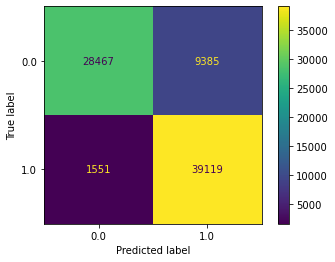

In [625]:
cm = confusion_matrix(y_test, test_predictions, labels=algo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=algo.classes_)
disp.plot()

Recall is important when identifying illegal fishing -- we must be able to identify all the boats that are actually fishing to have a good idea of how much illegal fishing is occurring. If we get to the point where we overclassify fishing, but within those classifications, all those who are truly fishing are included, our illegal fishing estimate will only be an overestimate, as opposed to an underestimate.

As an objective interpretation of this graph, we can see that the model tends to overclassify fishing regardless of whether or not the boat is actually fishing. But, if the boat is truly fishing, then the model almost always says that it is.

Next steps are to apply the MMSI spoofing algorithm to prevent unrealistic jumps in the coordinates, improve the AUC by trying individual gear types on the model, try a model without the engineered variable, and inspect feature importances.

In [626]:
fi = algo.feature_importances_
print(np.sort(fi))

[1.33205026e-04 2.15293656e-04 2.50078852e-04 3.53246148e-04
 3.64779087e-04 3.70125059e-04 3.83956140e-04 4.21292861e-04
 5.45025910e-04 8.57731666e-04 9.16420794e-04 1.01072954e-03
 1.21047295e-03 1.42361320e-03 1.48532722e-03 2.27259546e-03
 2.63565667e-03 3.16887879e-03 4.33480304e-03 1.17187819e-02
 1.92244395e-02 2.73385786e-02 3.37075165e-02 3.44987937e-02
 4.14829833e-02 8.78322805e-02 2.77457110e-01 4.44386284e-01]
